# Person Segmentation

In [15]:
import os
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import threading
import multiprocessing
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras.layers import Activation, Lambda, GlobalAveragePooling2D, concatenate
from tensorflow.keras.layers import UpSampling2D, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
from PIL import Image, ImageOps

In [4]:
tf.__version__

'2.4.0'

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

* read data into X(original images) and y(segmented images)
* resize to largest image found (all share the same aspect reation)
* convert y to grayscale
* return numpy arrays

In [6]:
size = 256, 144

# read data into X(original images) and y(segmented images)
# resize to largest image found (all share the same aspect reation)
# convert y to grayscale
# return numpy arrays
def preprocess_data(data_base_dir, raw_data_dir):
    file_names = np.array(sorted(os.listdir(raw_data_dir)[0:]))

    X_file_names = file_names[1::4]
    y_file_names = file_names[3::4] 

    for index, (X_file_name, y_file_name) in tqdm(enumerate(zip(X_file_names, y_file_names))):
        if index == 300: break

        X_image = Image.open(raw_data_dir / X_file_name)
        X_image_resized = X_image.resize(size, Image.ANTIALIAS)
        X_image_resized.save(data_base_dir / f"images/{index}.png")

        y_image = Image.open(raw_data_dir / y_file_name)
        y_image_resized = y_image.resize(size, Image.ANTIALIAS)
        y_image_resized_grayscale = ImageOps.grayscale(y_image_resized)
        y_image_resized_grayscale_binary = y_image_resized_grayscale.point(lambda p: p > 0 and 255)
        y_image_resized_grayscale_binary.save(data_base_dir / f"masks/{index}.png")


In [25]:
def get_train_generator(data_base_dir):
    seed = 909

    # ["constant", "nearest", "reflect", "wrap"]
    image_datagen = ImageDataGenerator("""
        width_shift_range=0.2,
        height_shift_range=0.2,
        rotation_range=90,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5, 1],
        zoom_range=[0.5, 1],
        fill_mode="reflect""")

    mask_datagen = ImageDataGenerator("""
        width_shift_range=0.2,
        height_shift_range=0.2,
        rotation_range=90,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.5, 1],
        zoom_range=[0.5, 1],
        fill_mode="reflect"
        """)

    image_generator =image_datagen.flow_from_directory(data_base_dir / "images", class_mode=None, seed=seed, target_size=size, color_mode='rgb')
    mask_generator = mask_datagen.flow_from_directory(data_base_dir / "masks", class_mode=None, seed=seed, target_size=size, color_mode='grayscale')
    
    train_generator = zip(image_generator, mask_generator)

    return train_generator
        

In [26]:
DATA_BASE_DIR = Path("../data")
DATA_RAW_DIR = DATA_BASE_DIR / "raw"
preprocess_data(DATA_BASE_DIR, DATA_RAW_DIR)



300it [00:17, 17.29it/s]


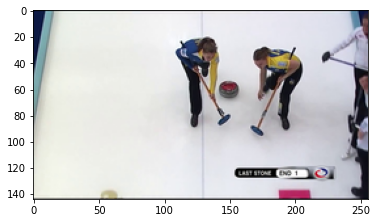

In [27]:
plt.imshow(Image.open(DATA_BASE_DIR / "images" / "0.png"))

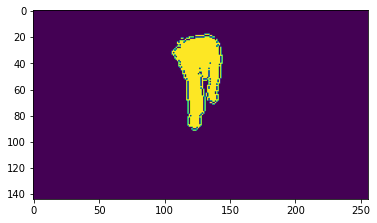

In [28]:
plt.imshow(Image.open(DATA_BASE_DIR / "masks" / "0.png"))

In [11]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c


In [44]:
def UNet2():
    in1 = Input(shape=(size[1], size[0], 3 ))

    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(in1)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)

    up1 = concatenate([UpSampling2D((2, 2))(conv4), conv3], axis=-1)
    conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up1)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)
    
    up2 = concatenate([UpSampling2D((2, 2))(conv5), conv2], axis=-1)
    conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)

    up2 = concatenate([UpSampling2D((2, 2))(conv6), conv1], axis=-1)
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(up2)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    segmentation = Conv2D(1, (1, 1), activation='sigmoid', name='seg')(conv7)

    model = Model(inputs=[in1], outputs=[segmentation])

    return model

In [13]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((size[1], size[0], 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [45]:
model = UNet2()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc"])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 144, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 144, 256, 32) 896         input_5[0][0]                    
__________________________________________________________________________________________________
dropout_28 (Dropout)            (None, 144, 256, 32) 0           conv2d_56[0][0]                  
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 144, 256, 32) 9248        dropout_28[0][0]                 
____________________________________________________________________________________________

In [47]:
IMAGE_DATA_DIR = DATA_BASE_DIR / 'images' / 'img'
MASK_DATA_DIR = DATA_BASE_DIR / 'masks' / 'img'

def get_images():
    file_list = sorted(os.listdir(IMAGE_DATA_DIR)[:50])
    loaded_files = []
    for f in file_list:
        loaded_files.append(np.array(Image.open(IMAGE_DATA_DIR / f)))
    return np.array(loaded_files)

def get_masks():
    file_list = sorted(os.listdir(MASK_DATA_DIR)[:50])
    loaded_files = []
    for f in file_list:
        loaded_files.append(np.array(Image.open(MASK_DATA_DIR / f)))
    return np.array(loaded_files)

In [48]:
X = get_images()
Y = get_masks()

In [49]:
X.shape

(50, 144, 256, 3)

In [51]:
model.fit(X, Y, epochs=5, batch_size=5)

Epoch 1/5
10/10 [==============================] - 74s 111ms/step - loss: -344.4548 - acc: 0.0000e+00
Epoch 2/5
10/10 [==============================] - 1s 116ms/step - loss: -344.4548 - acc: 0.0000e+00
Epoch 3/5
10/10 [==============================] - 1s 117ms/step - loss: -344.4548 - acc: 0.0000e+00
Epoch 4/5
10/10 [==============================] - 1s 116ms/step - loss: -344.4548 - acc: 0.0000e+00
Epoch 5/5
10/10 [==============================] - 1s 122ms/step - loss: -344.4548 - acc: 0.0000e+00
